# Supply Chain Data Preprocessing & Analysis

# 1. Initial Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Load dataset
file_path = "../Data/dynamic_supply_chain_logistics_dataset.csv"
df = pd.read_csv(file_path)

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Display initial information
print("👉🏼 Dataset Shape:", df.shape)
print("\n👉🏼 Data Types:")
df.info()

👉🏼 Dataset Shape: (32065, 26)

👉🏼 Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32065 entries, 0 to 32064
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   timestamp                        32065 non-null  object 
 1   vehicle_gps_latitude             32065 non-null  float64
 2   vehicle_gps_longitude            32065 non-null  float64
 3   fuel_consumption_rate            32065 non-null  float64
 4   eta_variation_hours              32065 non-null  float64
 5   traffic_congestion_level         32065 non-null  float64
 6   warehouse_inventory_level        32065 non-null  float64
 7   loading_unloading_time           32065 non-null  float64
 8   handling_equipment_availability  32065 non-null  float64
 9   order_fulfillment_status         32065 non-null  float64
 10  weather_condition_severity       32065 non-null  float64
 11  port_congestion_level            3

# 2. Data Cleaning and Type Conversion

In [2]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
duplicates = df.duplicated().sum()

print('👉🏼 Missing Values Analysis:')
print(missing_percentages[missing_percentages > 0])
print(f'\n👉🏼 Duplicate rows: {duplicates}')

print('\n👉🏼 Numerical Columns Statistics:')
print(df.select_dtypes(include=['float64', 'int64']).describe())

👉🏼 Missing Values Analysis:
Series([], dtype: float64)

👉🏼 Duplicate rows: 0

👉🏼 Numerical Columns Statistics:
       vehicle_gps_latitude  vehicle_gps_longitude  fuel_consumption_rate  \
count          32065.000000           32065.000000           32065.000000   
mean              38.023589             -90.116648               8.011735   
std                6.917909              17.369244               4.264960   
min               30.000000            -119.999998               5.000000   
25%               31.280550            -106.253913               5.019984   
50%               36.413820             -86.293414               5.636036   
75%               44.453655             -73.079367               9.669944   
max               50.000000             -70.000000              19.999875   

       eta_variation_hours  traffic_congestion_level  \
count         32065.000000              3.206500e+04   
mean              2.893068              4.991493e+00   
std               2.274044 

# 3. Feature Engineering

In [3]:
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month

df['total_risk_score'] = (df['disruption_likelihood_score'] + 
                        df['route_risk_level'] + 
                        df['delay_probability']) / 3

df['delivery_efficiency'] = 100 - (abs(df['delivery_time_deviation']) * 10 + 
                                 abs(df['eta_variation_hours']) * 5)

df['delay_category'] = pd.cut(df['delivery_time_deviation'],
                            bins=[-float('inf'), -2, -0.5, 0.5, 2, float('inf')],
                            labels=['Very Early', 'Early', 'On Time', 'Late', 'Very Late'])

cols_to_normalize = ['driver_behavior_score', 'fatigue_monitoring_score', 
                    'supplier_reliability_score']

for col in cols_to_normalize:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min()) * 100

df['distance'] = np.sqrt(
    (df['vehicle_gps_latitude'].diff())**2 + 
    (df['vehicle_gps_longitude'].diff())**2
)

first_rows_mean = df['distance'][1:6].mean()
df['distance'] = df['distance'].fillna(first_rows_mean).round(3)

print("\nShape of dataset:", df.shape)
print("\nNew columns added:", 
      [col for col in df.columns if col not in ['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude', 
       'fuel_consumption_rate', 'eta_variation_hours', 'traffic_congestion_level', 
       'warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability',
       'order_fulfillment_status', 'weather_condition_severity', 'port_congestion_level',
       'shipping_costs', 'supplier_reliability_score', 'lead_time_days', 'historical_demand',
       'iot_temperature', 'cargo_condition_status', 'route_risk_level', 'customs_clearance_time',
       'driver_behavior_score', 'fatigue_monitoring_score', 'disruption_likelihood_score',
       'delay_probability', 'risk_classification', 'delivery_time_deviation']])


Shape of dataset: (32065, 34)

New columns added: ['date', 'hour', 'day_of_week', 'month', 'total_risk_score', 'delivery_efficiency', 'delay_category', 'distance']


# 4. Performance Metrics Creation

In [4]:
# Add delivery performance score
df['delivery_performance'] = df.apply(lambda x: 
    100 * (1 - abs(x['delivery_time_deviation'])/10) * 
    (1 - x['delay_probability']) * 
    (1 - x['disruption_likelihood_score']), axis=1)

# Add cost efficiency metric
df['cost_efficiency'] = df['shipping_costs'].mean() / df['shipping_costs'] * 100

In [5]:
df[['total_risk_score', 'delivery_efficiency', 'delay_category', 'distance','delivery_performance','cost_efficiency']].head()

,total_risk_score,delivery_efficiency,delay_category,distance,delivery_performance,cost_efficiency
0,0.857853,-16.096864,Very Late,30.121,0.503787,100.628822
1,3.712317,13.322543,Very Late,40.608,0.159829,71.731506
2,2.790795,62.300737,Late,41.913,0.023440,294.944768
3,0.522750,-8.524289,Very Late,8.351,0.045225,440.359886
4,3.588333,6.394778,Very Late,6.650,0.017473,47.008173


# 5. Outlier Detection and Handling

In [ ]:
decimal_handling = {
    # GPS coordinates (higher precision needed)
    'vehicle_gps_latitude': 6,
    'vehicle_gps_longitude': 6,
    # Distance and time measurements
    'distance': 3,
    'eta_variation_hours': 2,
    'lead_time_days': 1,
    'loading_unloading_time': 2,
    'customs_clearance_time': 2,
    # Scores and metrics (2 decimals for percentage-based metrics)
    'driver_behavior_score': 2,
    'fatigue_monitoring_score': 2,
    'supplier_reliability_score': 2,
    'delivery_efficiency': 2,
    'total_risk_score': 2,
    'cost_efficiency': 2,
    'delivery_performance': 2,
    # Other measurements
    'fuel_consumption_rate': 2,
    'shipping_costs': 2,
    'iot_temperature': 1,
    # Probabilities and indices (3 decimals for more precise probability values)
    'delay_probability': 3,
    'disruption_likelihood_score': 3
}

# Apply rounding to specified columns
for col, decimals in decimal_handling.items():
    if col in df.columns:
        df[col] = df[col].round(decimals)



fuel_consumption_rate - Outliers: 2536 (7.91%)


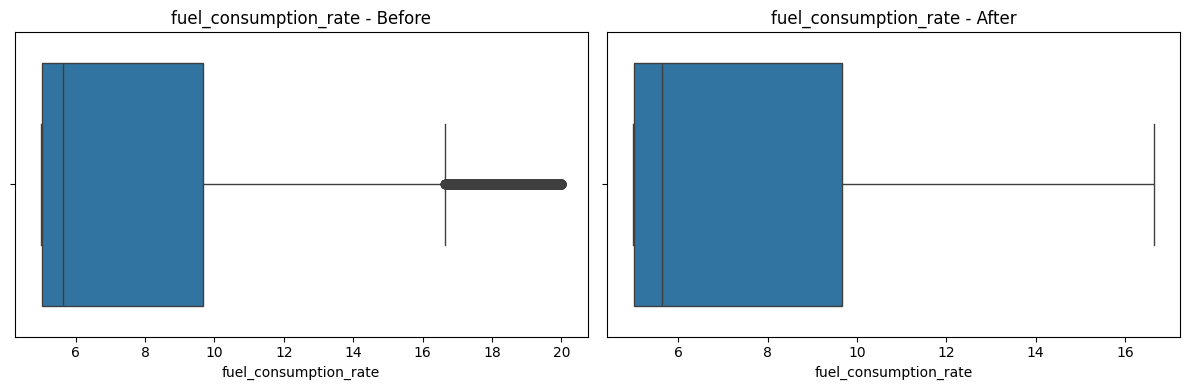


eta_variation_hours - Outliers: 0 (0.00%)


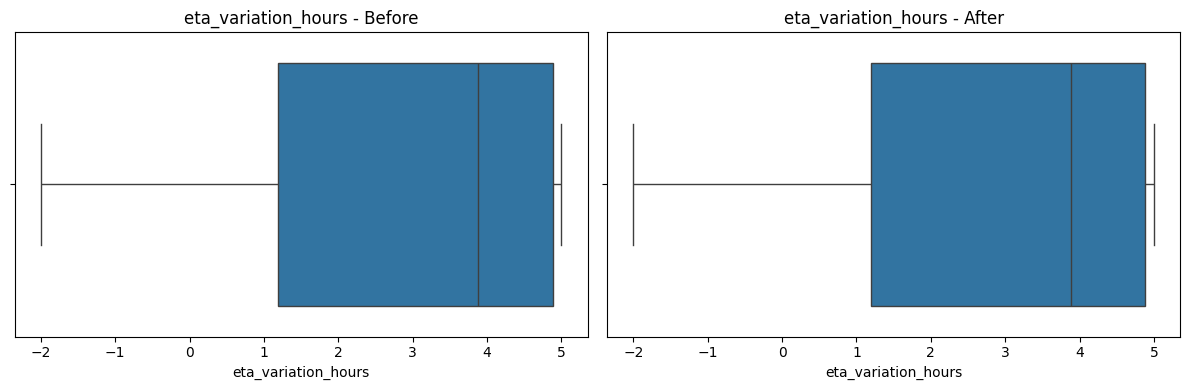


traffic_congestion_level - Outliers: 0 (0.00%)


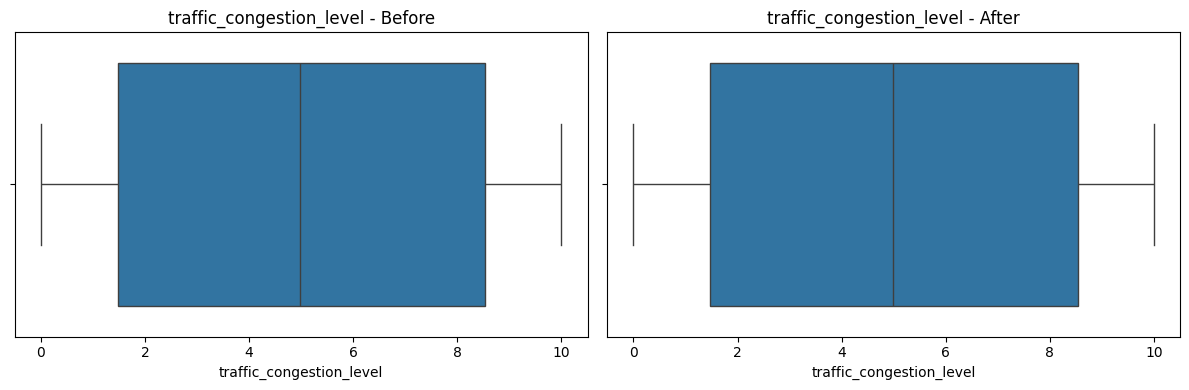


warehouse_inventory_level - Outliers: 0 (0.00%)


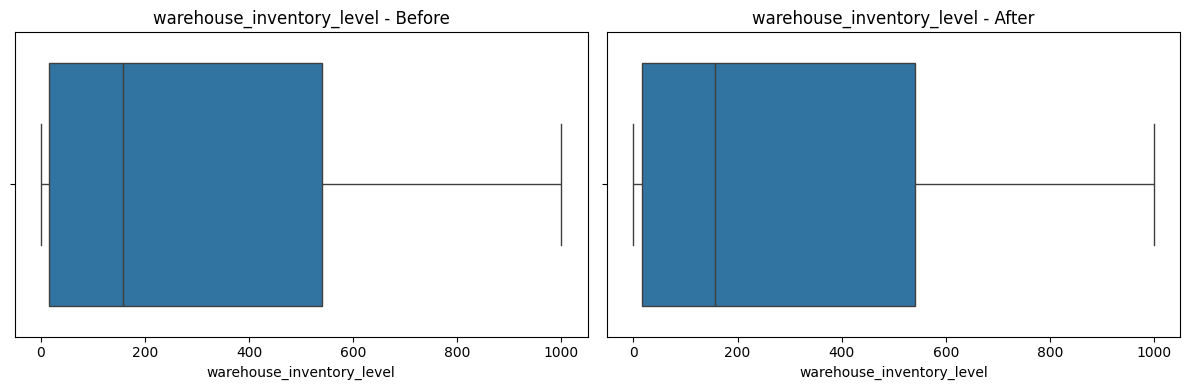


loading_unloading_time - Outliers: 0 (0.00%)


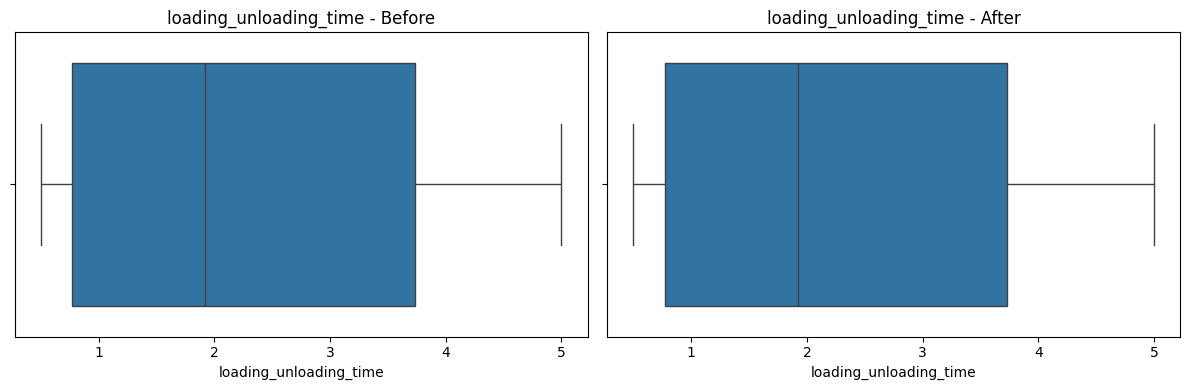


handling_equipment_availability - Outliers: 0 (0.00%)


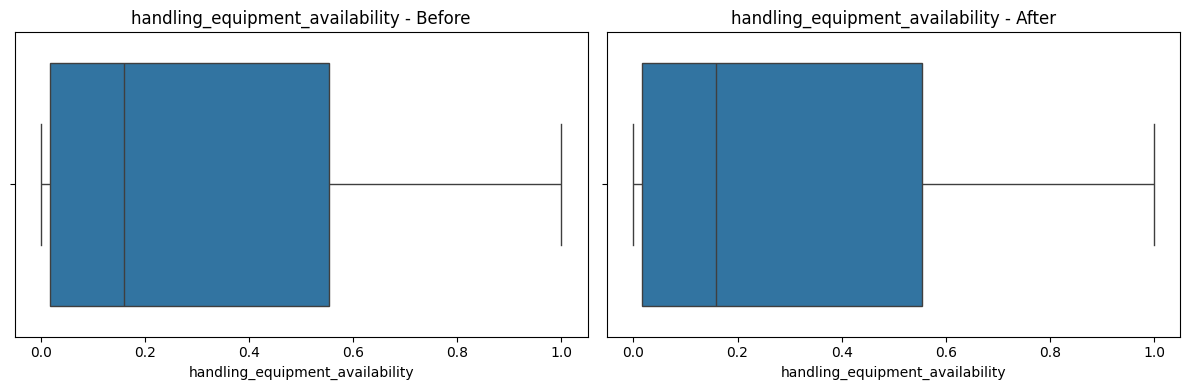


order_fulfillment_status - Outliers: 0 (0.00%)


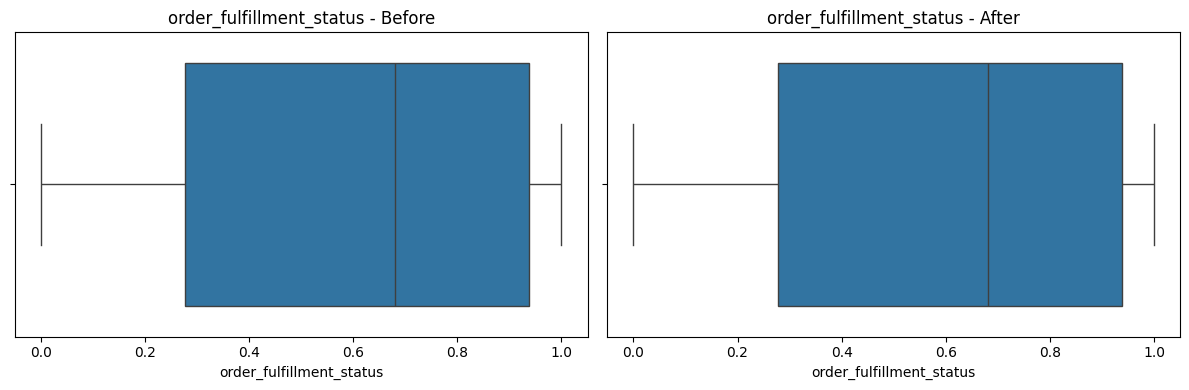


weather_condition_severity - Outliers: 0 (0.00%)


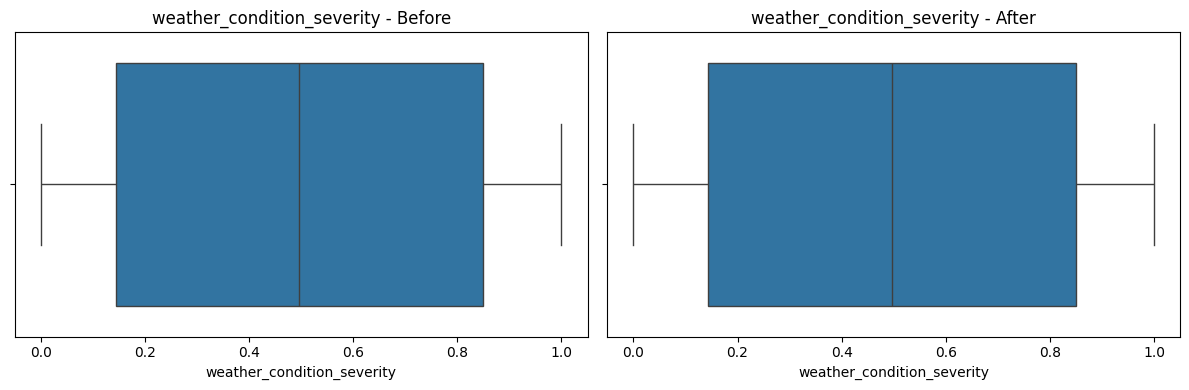


port_congestion_level - Outliers: 0 (0.00%)


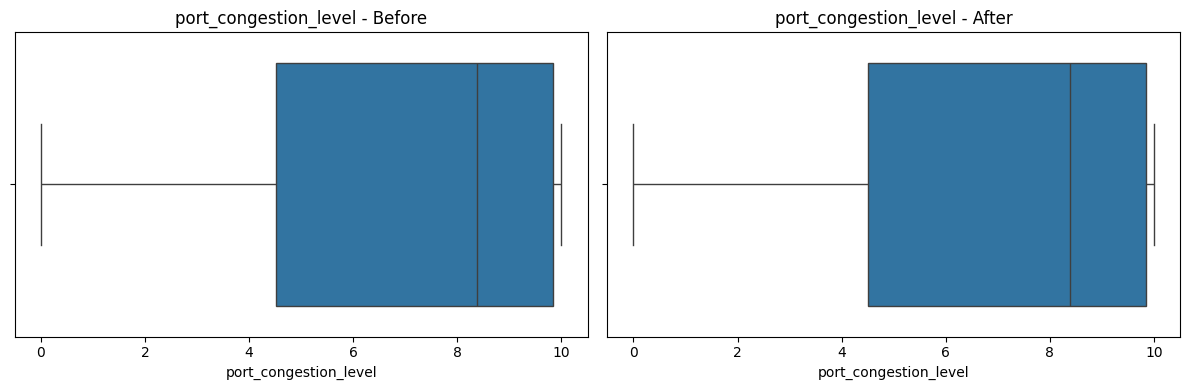


shipping_costs - Outliers: 0 (0.00%)


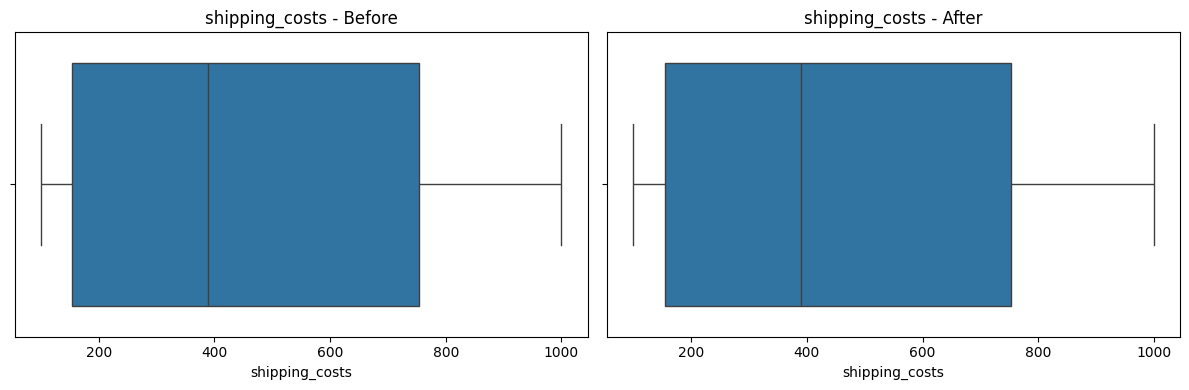


lead_time_days - Outliers: 0 (0.00%)


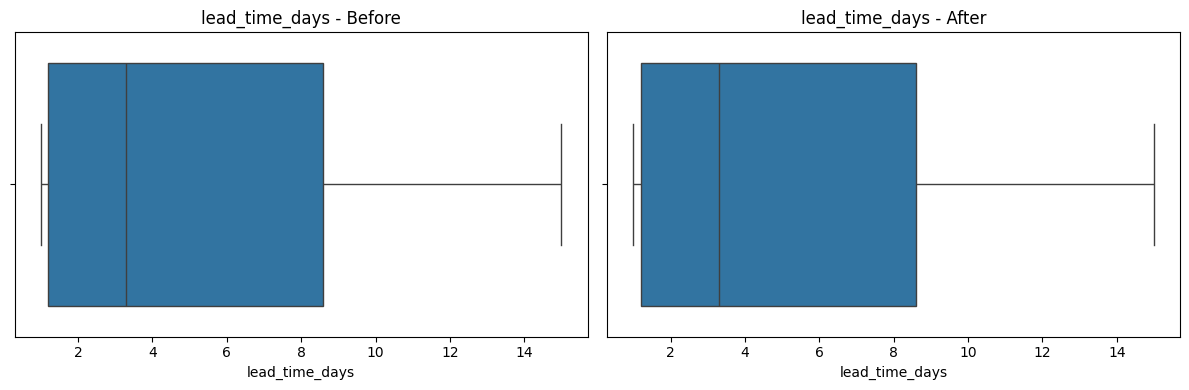


historical_demand - Outliers: 0 (0.00%)


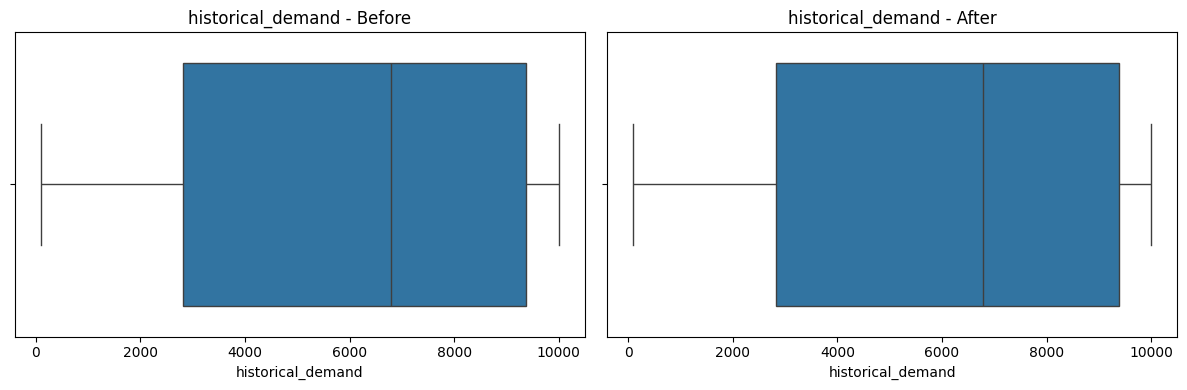


iot_temperature - Outliers: 1332 (4.15%)


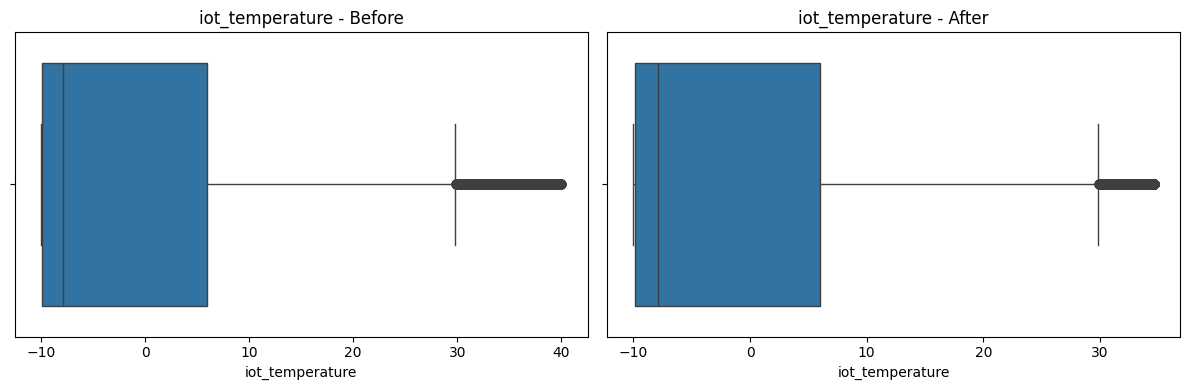


cargo_condition_status - Outliers: 0 (0.00%)


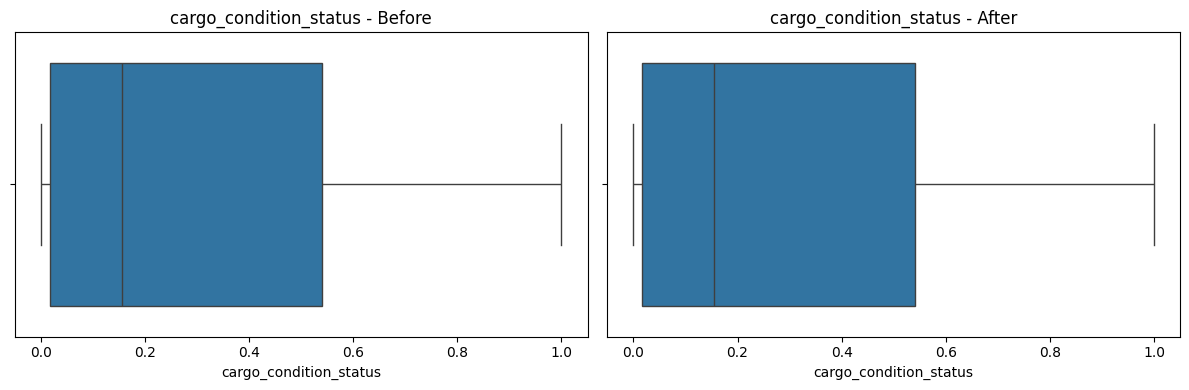


route_risk_level - Outliers: 0 (0.00%)


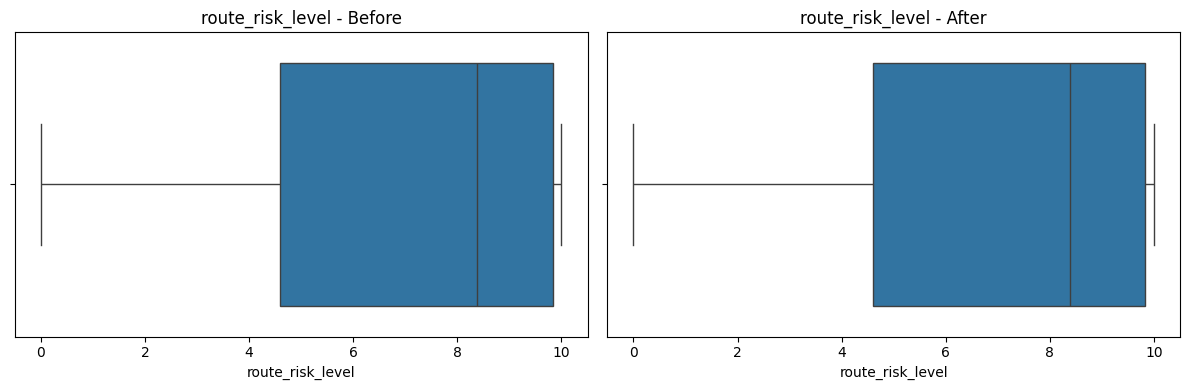


customs_clearance_time - Outliers: 0 (0.00%)


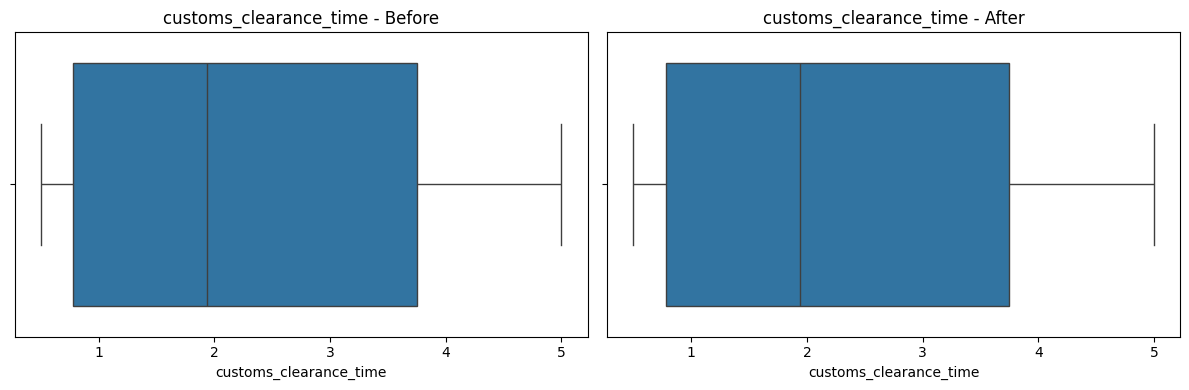


disruption_likelihood_score - Outliers: 2495 (7.78%)


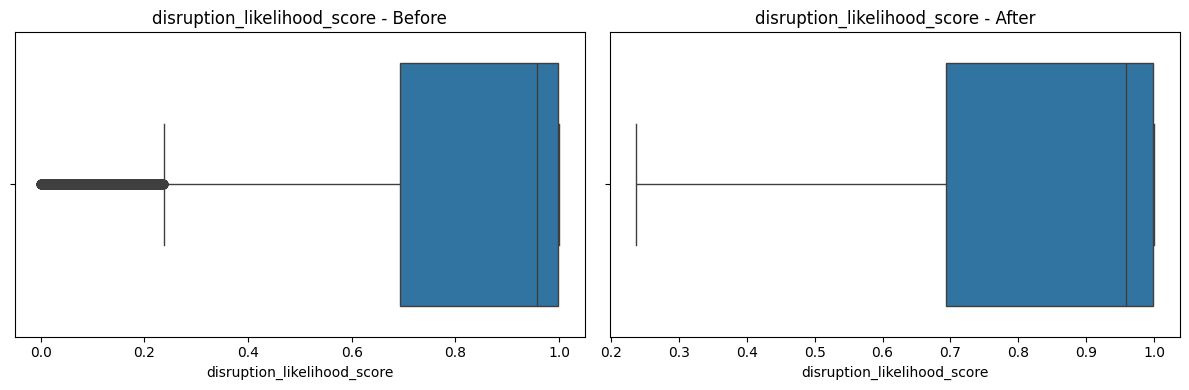


delivery_time_deviation - Outliers: 0 (0.00%)


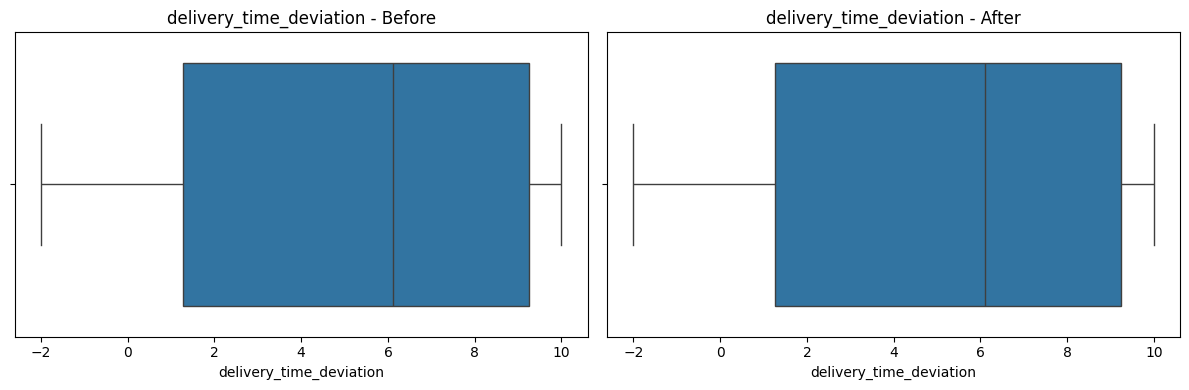


total_risk_score - Outliers: 0 (0.00%)


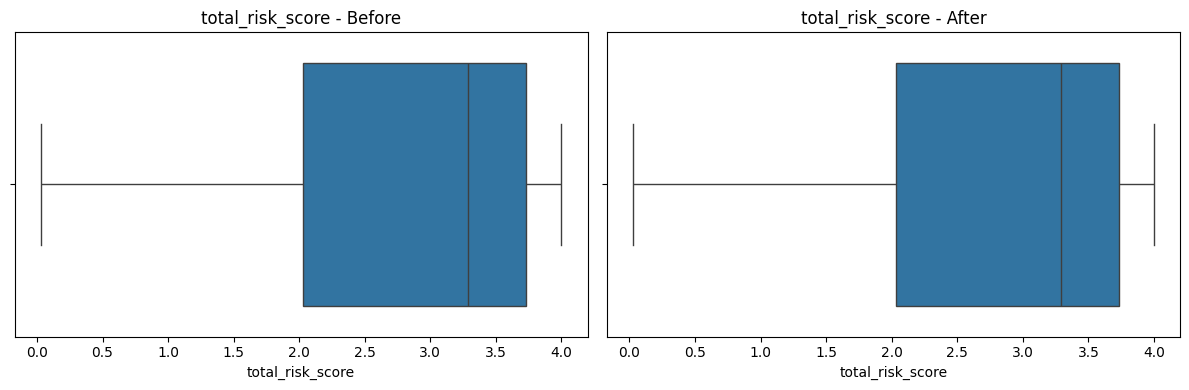


Total outliers handled: 6363


In [7]:
# Columns to exclude from outlier handling
EXCLUDE_COLS = [
    'vehicle_gps_latitude', 
    'vehicle_gps_longitude',
    'month', 
    'hour',
    'delivery_efficiency',
    'cost_efficiency',
    'delivery_performance',
    'driver_behavior_score',
    'fatigue_monitoring_score',
    'supplier_reliability_score',
    'delay_probability',
    'distance'
]

# Custom IQR multipliers for specific columns
IQR_MULTIPLIERS = {
    'shipping_costs': 2.0,
    'historical_demand': 2.0,
    'iot_temperature': 1.8,
    'lead_time_days': 2.0,
}

def analyze_and_handle_outliers(df, column, iqr_multiplier=1.5, visualize=False):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - iqr_multiplier * IQR
    upper = Q3 + iqr_multiplier * IQR

    outliers = df[(df[column] < lower) | (df[column] > upper)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(df)) * 100

    if visualize:
        print(f"\n{column} - Outliers: {outlier_count} ({outlier_pct:.2f}%)")
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.boxplot(x=df[column], ax=axes[0])
        axes[0].set_title(f"{column} - Before")
        sns.boxplot(x=df[column].clip(lower, upper), ax=axes[1])
        axes[1].set_title(f"{column} - After")
        plt.tight_layout()
        plt.show()

    df[column] = df[column].clip(lower, upper)
    return outlier_count

# Handle outliers in all numeric columns except exclusions
total_outliers = 0
cols_to_handle = [
    col for col in df.select_dtypes(include=['float64', 'int64']).columns 
    if col not in EXCLUDE_COLS
]


for col in cols_to_handle:
    multiplier = IQR_MULTIPLIERS.get(col, 1.5)
    total_outliers += analyze_and_handle_outliers(df, col, multiplier, visualize=True)

print(f"\nTotal outliers handled: {total_outliers}")

# 6. Validate data quality after outlier handling

In [8]:
validation_results = {
    'timestamp_range': (df['timestamp'].min().year >= 2021) and 
                      (df['timestamp'].max().year <= 2025),
    'gps_coords_valid': all([-90 <= df['vehicle_gps_latitude'].max() <= 90,
                            -180 <= df['vehicle_gps_longitude'].max() <= 180]),
    'scores_normalized': all([(0 <= df[col].max() <= 100) and 
                            (0 <= df[col].min() <= 100) 
                            for col in ['driver_behavior_score', 
                                      'fatigue_monitoring_score',
                                      'supplier_reliability_score']])
}

print("\nValidation Results:")
for check, result in validation_results.items():
    print(f"{check}: {'✓' if result else '✗'}")


Validation Results:
timestamp_range: ✓
gps_coords_valid: ✓
scores_normalized: ✓


# 7. Final Export

In [9]:
cleaned_file_path = "../Data/cleaned_supply_chain_logistics_dataset.csv"
os.makedirs(os.path.dirname(cleaned_file_path), exist_ok=True)

# Save the cleaned dataset
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset saved to {cleaned_file_path}")

Cleaned dataset saved to ../Data/cleaned_supply_chain_logistics_dataset.csv
